In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Groceries_dataset.csv', header = 0)

In [3]:
#Change 'Date' column data type from object to Date
#create a separate Data Frame named orig_df, to be used for Most Frequently bought item Chart

df['Date'] = pd.to_datetime(df['Date'])
orig_df = df

In [5]:
orig_df['weekday'] = orig_df['Date'].dt.dayofweek

orig_df.head()

,Member_number,Date,itemDescription,weekday
0,1808,2015-07-21,tropical fruit,1
1,2552,2015-05-01,whole milk,4
2,2300,2015-09-19,pip fruit,5
3,1187,2015-12-12,other vegetables,5
4,3037,2015-01-02,whole milk,4


In [12]:
item_weekday = orig_df.groupby(['itemDescription', 'weekday']).size().unstack(fill_value = 0)

In [16]:
#0-6 = monday-sunday
item_weekday.sort_values(by = 6, ascending = False)[0:10]

weekday,0,1,2,3,4,5,6
itemDescription,,,,,,,
whole milk,349,343,389,359,337,347,378
other vegetables,230,303,279,264,272,266,284
rolls/buns,236,240,257,240,272,235,236
soda,222,225,236,214,197,203,217
yogurt,190,191,193,168,202,209,181
sausage,118,132,131,135,127,119,162
tropical fruit,133,145,149,180,141,129,155
root vegetables,149,156,151,161,157,147,150
bottled water,127,135,132,159,129,119,132


In [17]:
### Item Frequency Plot - using original df
item_freq = orig_df['itemDescription'].value_counts().sort_values(ascending = False)
item_perc = (orig_df['itemDescription'].value_counts() / len(df['itemDescription']) * 100).sort_values(ascending = False)

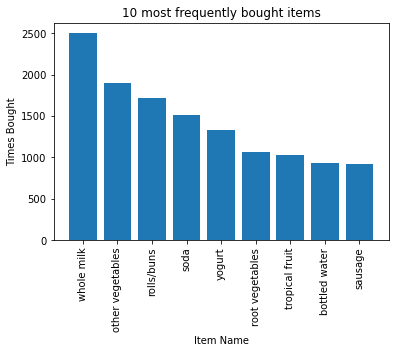

<Figure size 2560x1920 with 0 Axes>

In [18]:
plt.bar(x = item_freq.index[0:9], 
        height = item_freq.values[0:9])
plt.xlabel('Item Name')
plt.xticks(rotation=90)
plt.ylabel('Times Bought')
plt.title('10 most frequently bought items')
plt.figure(figsize=(32, 24), dpi=80)
plt.show()

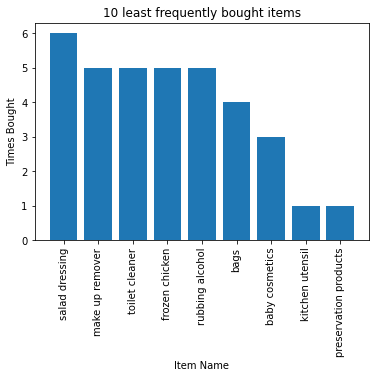

<Figure size 2560x1920 with 0 Axes>

In [19]:
plt.bar(x = item_freq.index[-9:], 
        height = item_freq.values[-9:])
plt.xlabel('Item Name')
plt.xticks(rotation=90)
plt.ylabel('Times Bought')
plt.title('10 least frequently bought items')
plt.figure(figsize=(32, 24), dpi=80)
plt.show()

In [20]:
#recreated itemDescription column, that was joined based on Member_number and Date, 
#basically means items bought on a single transaction
#weekday dictionary to replace weekday column (created by df['Date'].dt.dayofweek) to replace 0-6 with monday-sunday

df = df.groupby(['Member_number','Date'])['itemDescription'].apply(','.join).reset_index()

weekday = {
  0: "Monday",
  1: "Tuesday",
  2: 'Wednesday',
  3: "Thursday",
  4: "Friday",
  5: "Saturday",
  6: "Sunday",
}

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.dayofweek
df['weekday'] = df.weekday.map(weekday)

new_columns = ['Member_number', 'Date', 'year','month','day','weekday','itemDescription']
df = df[new_columns]


df.head()

,Member_number,Date,year,month,day,weekday,itemDescription
0,1000,2014-06-24,2014,6,24,Tuesday,"whole milk,pastry,salty snack"
1,1000,2015-03-15,2015,3,15,Sunday,"sausage,whole milk,semi-finished bread,yogurt"
2,1000,2015-05-27,2015,5,27,Wednesday,"soda,pickled vegetables"
3,1000,2015-07-24,2015,7,24,Friday,"canned beer,misc. beverages"
4,1000,2015-11-25,2015,11,25,Wednesday,"sausage,hygiene articles"


In [21]:
#itemDescription splitted then expanded to separate each items (still under 1 transaction, since is inside 1 row)
#new_df is expanded, will be used for apriori
#df is not, to be used for item frequency plot


items = df['itemDescription'].str.split(',', expand = True)
new_df = df.join(items).drop('itemDescription', axis = 1)
new_df.head()

,Member_number,Date,year,month,day,weekday,0,1,2,3,4,5,6,7,8,9,10
0,1000,2014-06-24,2014,6,24,Tuesday,whole milk,pastry,salty snack,None,None,None,None,None,None,None,None
1,1000,2015-03-15,2015,3,15,Sunday,sausage,whole milk,semi-finished bread,yogurt,None,None,None,None,None,None,None
2,1000,2015-05-27,2015,5,27,Wednesday,soda,pickled vegetables,None,None,None,None,None,None,None,None,None
3,1000,2015-07-24,2015,7,24,Friday,canned beer,misc. beverages,None,None,None,None,None,None,None,None,None
4,1000,2015-11-25,2015,11,25,Wednesday,sausage,hygiene articles,None,None,None,None,None,None,None,None,None


In [22]:
#Apriori
#Took the items columns 0-10 then turned into a list that will be used for the apriori

transactions = new_df.iloc[:, 6:].astype(str).values.tolist()

In [23]:
#min_support -> how often the transaction happened
#min_confidence -> how much of item 1 are also buyers of item 2
#min_lift -> how much did the buyers of item 1 improved the probability of item 2 being bought


from apyori import apriori
rules = apriori(transactions = transactions, min_support = 0.001, min_confidence = 0.05, 
                min_lift = 1.25, min_length = 2, max_length = 2)

results = list(rules)
len(results)

21

In [24]:
#Function for better readability of the apriori function

def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [25]:
resultsinDataFrame.nlargest(n = 10, columns = 'Support')

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
8,curd,sausage,0.002941,0.087302,1.446615
2,brown bread,canned beer,0.002406,0.063943,1.362937
14,napkins,pastry,0.001738,0.078550,1.518529
0,beverages,sausage,0.001537,0.092742,1.536764
4,white bread,canned beer,0.001537,0.064067,1.365573
1,sugar,bottled water,0.001470,0.083019,1.368074
16,processed cheese,rolls/buns,0.001470,0.144737,1.315734
6,chewing gum,yogurt,0.001403,0.116667,1.358508
7,specialty chocolate,citrus fruit,0.001403,0.087866,1.653762
11,frozen meals,sausage,0.001270,0.075697,1.254327
